# R019 : Number of bidders significantly less than average, based on prior similar contracts (for similar item or procuring entity) 

In [54]:
import psycopg2
from psycopg2 import OperationalError
from psycopg2 import sql
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import HTML
import webbrowser
from collections import defaultdict
import networkx as nx
import csv
import os
from statsmodels.stats.stattools import medcouple 

os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')



# LIGAÇÃO À BASE DE DADOS
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")
cur = conn.cursor()

In [55]:
cur.execute('''ROLLBACK;''')

# PARTE 1 

Construir tabela nova : indicadores estatísticos para concursos públicos por CPV

In [56]:
cur = conn.cursor()
cur.execute('''
            SELECT contratos_basegov."id", contratos_basegov."cpv", concursos_publicos."nr_entidadesconcorrentes", cpv_stat."q1", cpv_stat."q2",cpv_stat."q3" 
            FROM contratos_basegov 
            JOIN concursos_publicos ON contratos_basegov."id" = concursos_publicos."id"
            JOIN cpv_stat ON SUBSTRING(contratos_basegov."cpv", 1, 2) = cpv_stat."cpv"
            ORDER BY contratos_basegov."data_publicacao" DESC
            LIMIT 1;
            ''')

for i in cur.fetchall():
    print(i, '\n')

(10768923, '19640000-4', 1, 2.0, 4.0, 5.0) 



In [57]:
# Dataframe com CPV(2 digitos), ID e NR_entidadesconcorrentes
cur = conn.cursor()
cur.execute('''
            SELECT SUBSTRING(contratos_basegov."cpv", 1, 2), nr_entidadesconcorrentes
            FROM concursos_publicos
            JOIN contratos_basegov ON contratos_basegov."id" = concursos_publicos."id";
            ''')

data = pd.DataFrame(cur.fetchall())

## Parte 1.1 : Plot da distribuição de NEC

In [60]:
# PLOTS POUCO INTERESSANTES

data = data.rename(columns={0:'cpv', 1:'nec'})

data_sorted = data.sort_values(by=['nec'], ascending=[False])

#g = sns.FacetGrid(data=data_sorted, col='cpv', col_wrap=4)
#g.map(sns.histplot, 'nec', kde = True)
#plt.show()

**REPRESENTAR HISTOGRAMAS DO NEC PARA CADA DIVISÃO DO CPV**

In [61]:
data1 = data[data["cpv"] != 0]

In [62]:
CPV = data.iloc[:,0]
CPV = np.sort(CPV.unique())[::-1]

**REPRESENTAÇÃO DOS 46 HISTOGRAMAS EM 2 PLOTS DIFERENTES**

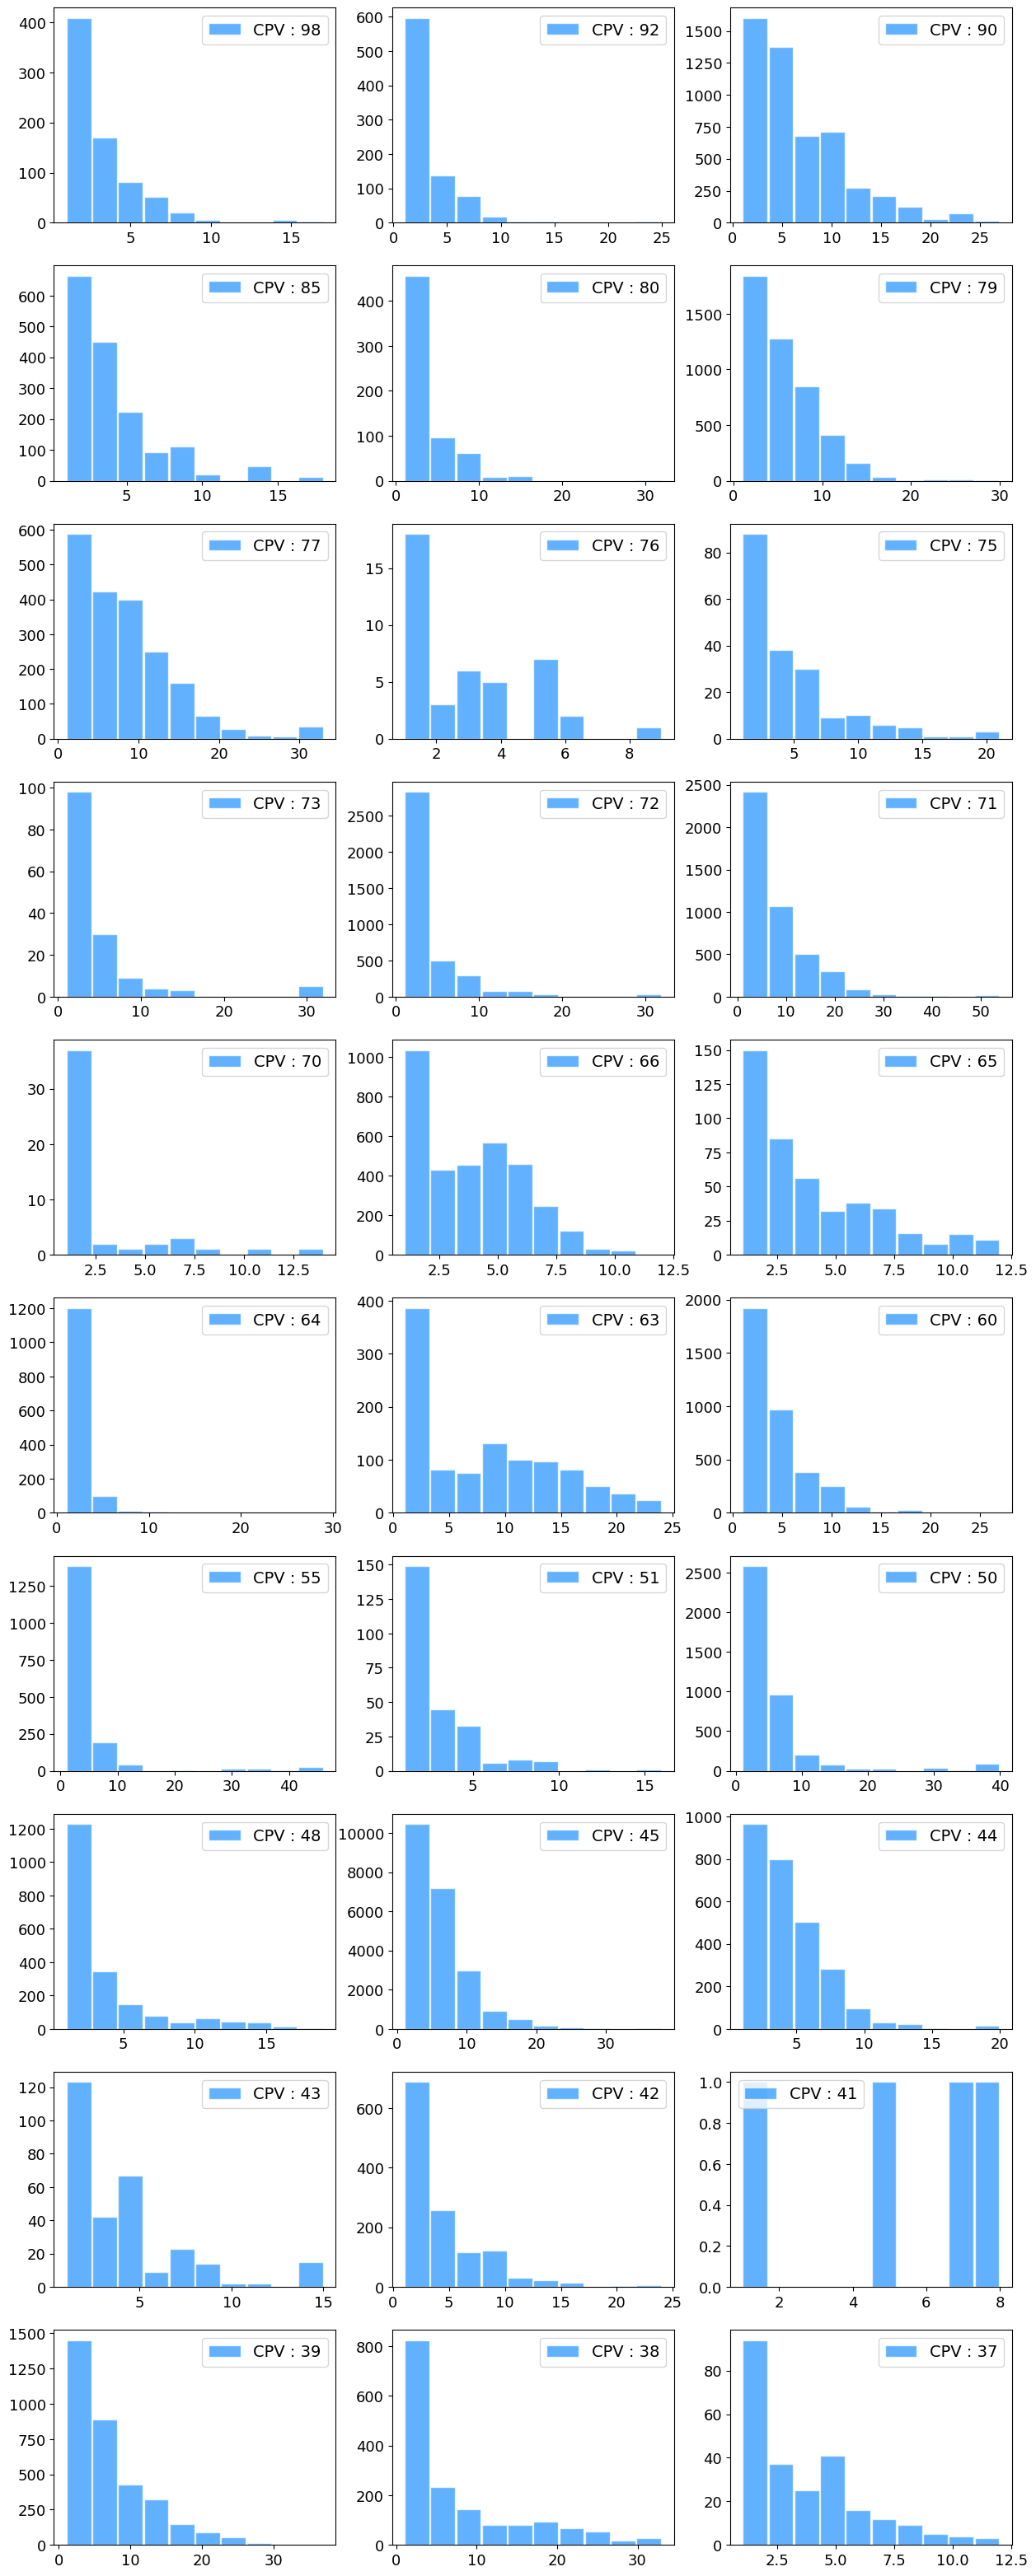

In [65]:
os.chdir("/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens")
figure, axis = plt.subplots(10, 3, figsize=(15,40))

counter = 0

for i in range(10):
    for j in range(3):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='dodgerblue', alpha = .7, rwidth=0.95, label = 'CPV : ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best', fontsize = 14)
        ax.yaxis.set_tick_params(labelsize=13)
        ax.xaxis.set_tick_params(labelsize=13)

plt.savefig("nec_histos_v1.png", dpi = 500, bbox_inches='tight')

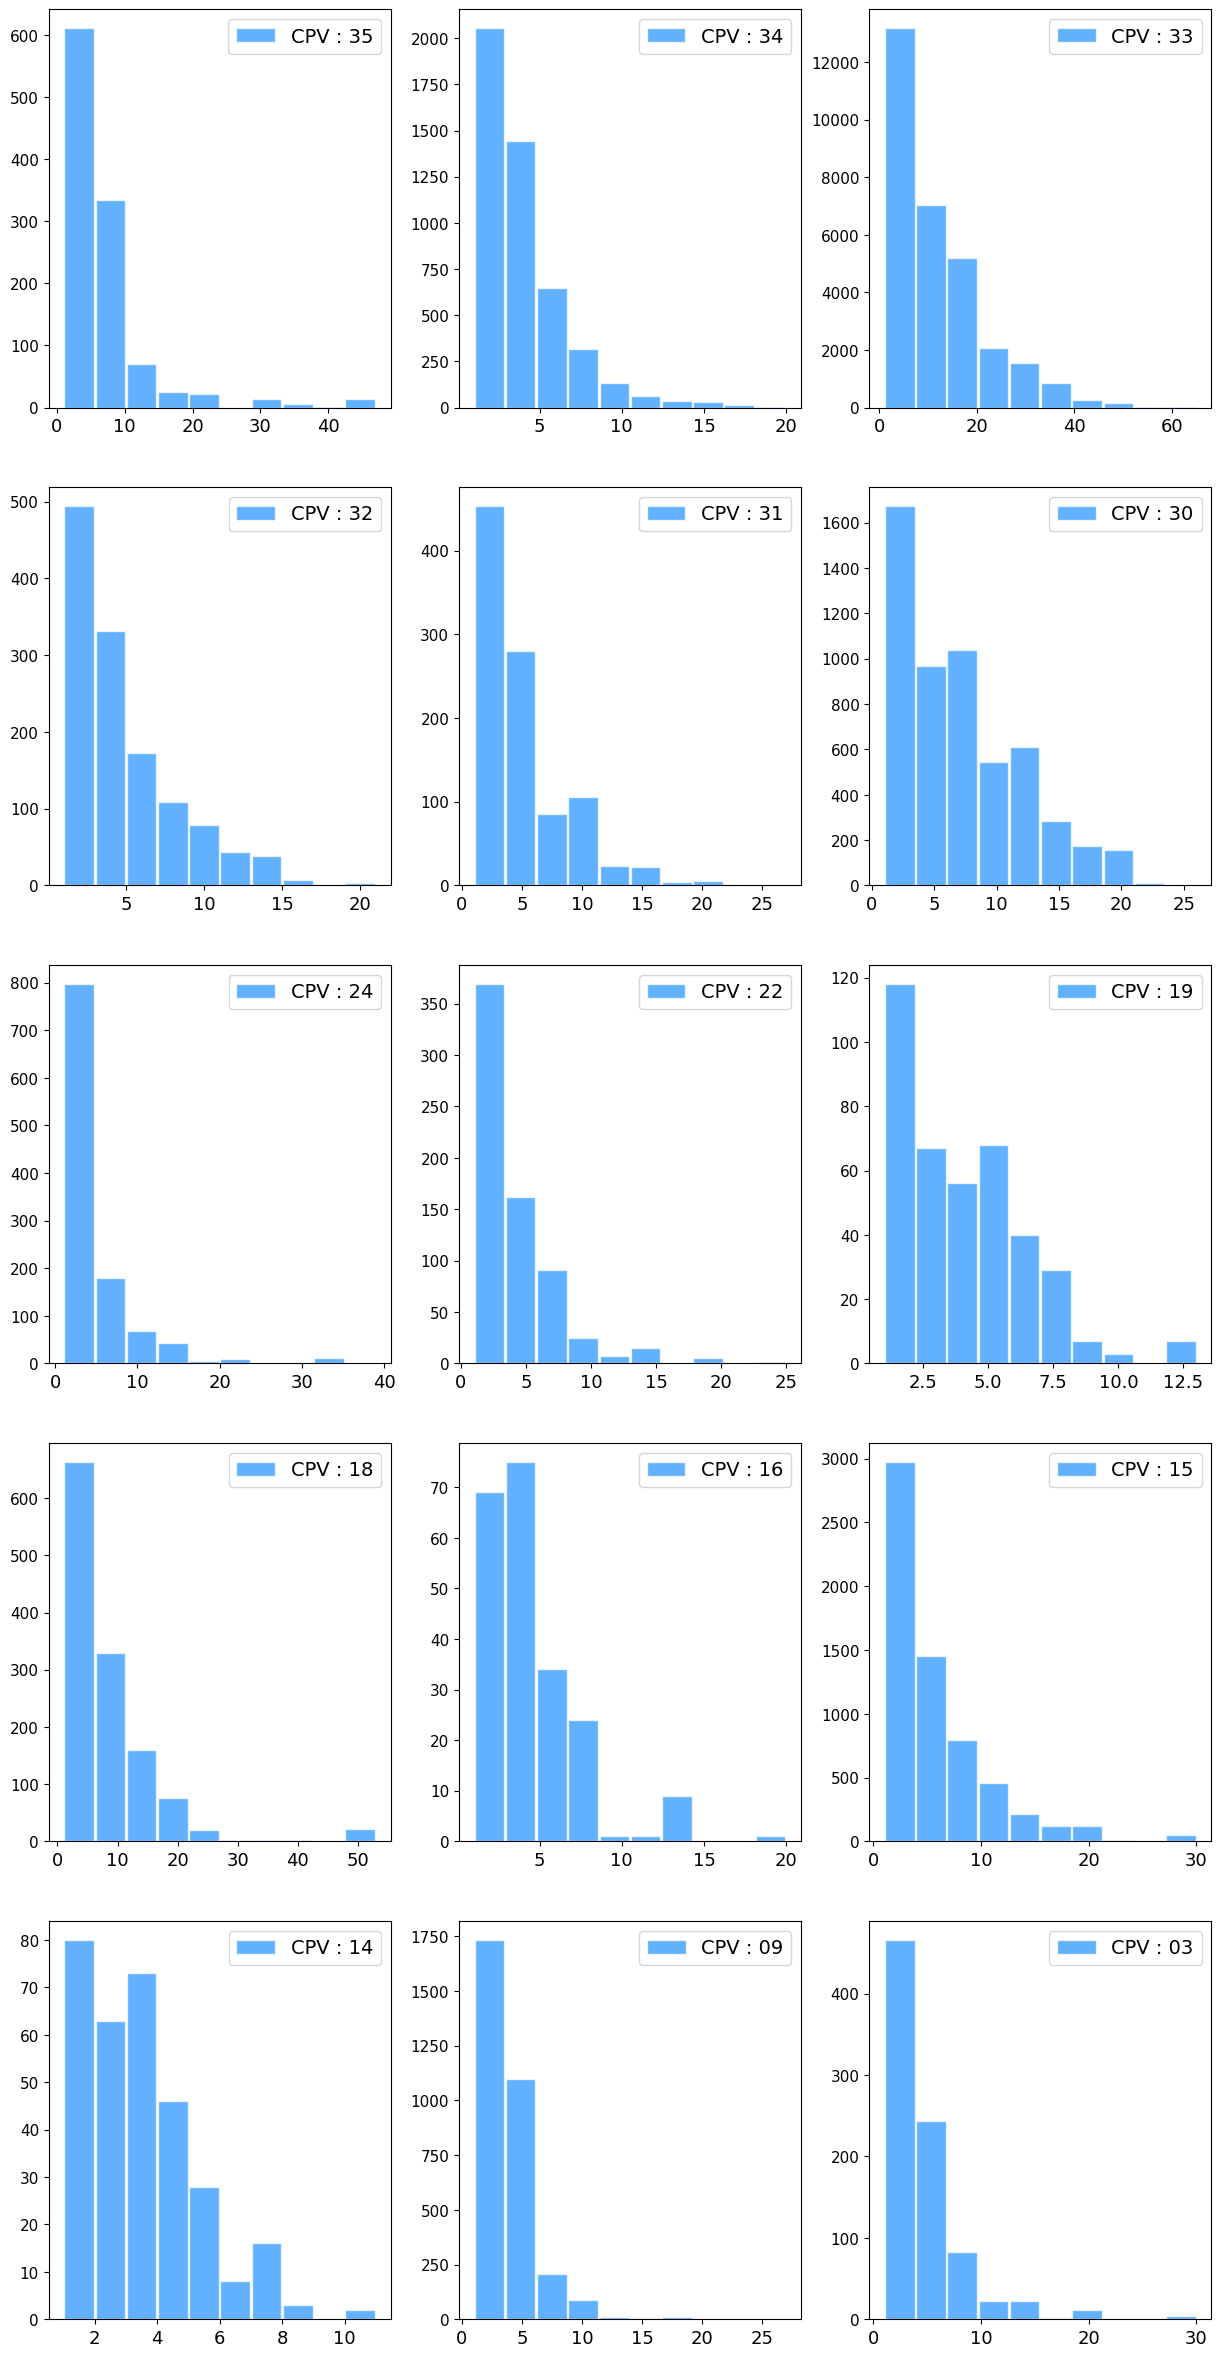

In [67]:
figure, axis = plt.subplots(5,3, figsize=(15,30))

counter = 30

for i in range(5):
    for j in range(3):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='dodgerblue', alpha = .7, rwidth=0.95, label = 'CPV : ' + str((CPV[counter])))
        counter += 1
        ax.legend(loc = 'best', fontsize = 14)
        ax.yaxis.set_tick_params(labelsize=11)
        ax.xaxis.set_tick_params(labelsize=13)

plt.savefig("nec_histos_v2.png", dpi = 500, bbox_inches='tight')

**REPRESENTAÇÃO DOS 46 HISTOGRAMAS EM 3 PLOTS DIFERENTES**

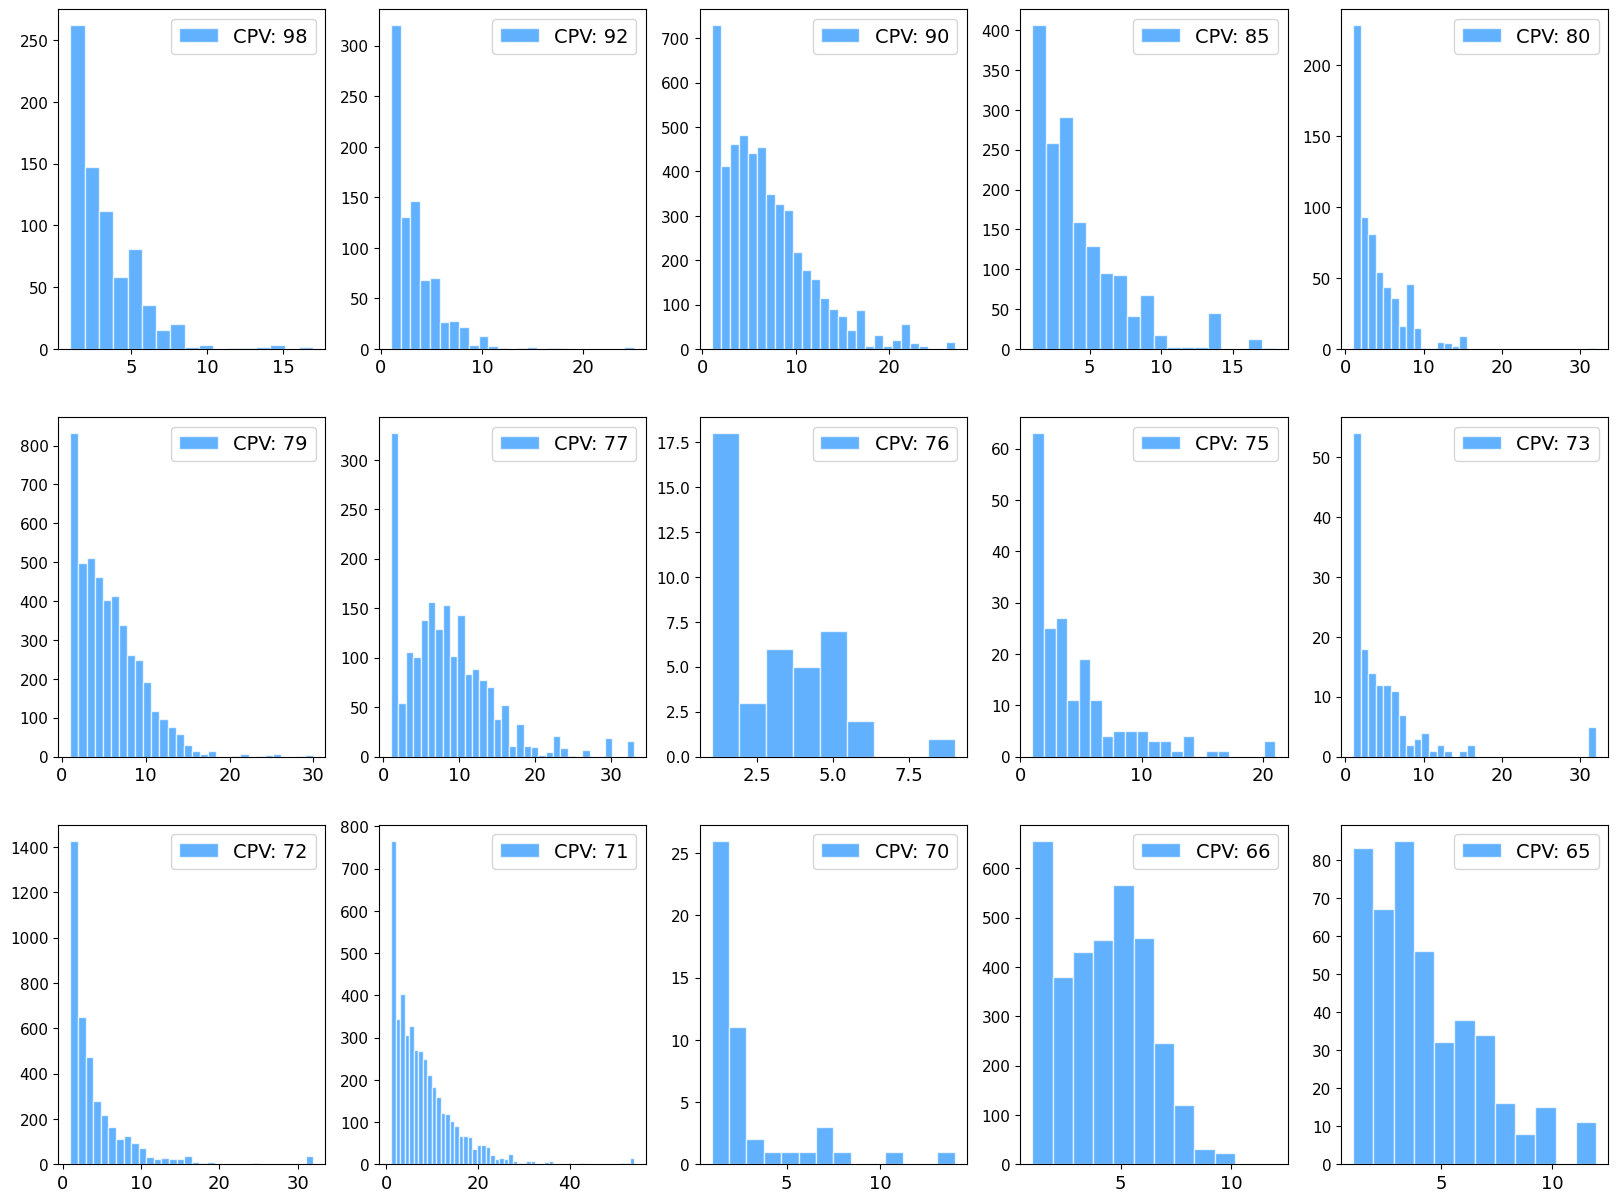

In [71]:
figure, axis = plt.subplots(3, 5, figsize=(20,15))

counter = 0

for i in range(3):
    for j in range(5):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]

        n_bins = np.max(np.unique(df))

        ax.hist(df, bins = n_bins, edgecolor='white', color='dodgerblue', alpha = .7, rwidth=1, label = 'CPV: ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best')
        ax.legend(loc = 'best', fontsize = 14)
        ax.yaxis.set_tick_params(labelsize=11)
        ax.xaxis.set_tick_params(labelsize=13)

plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019_hist1.png',dpi = 500 ,bbox_inches='tight')
plt.show()

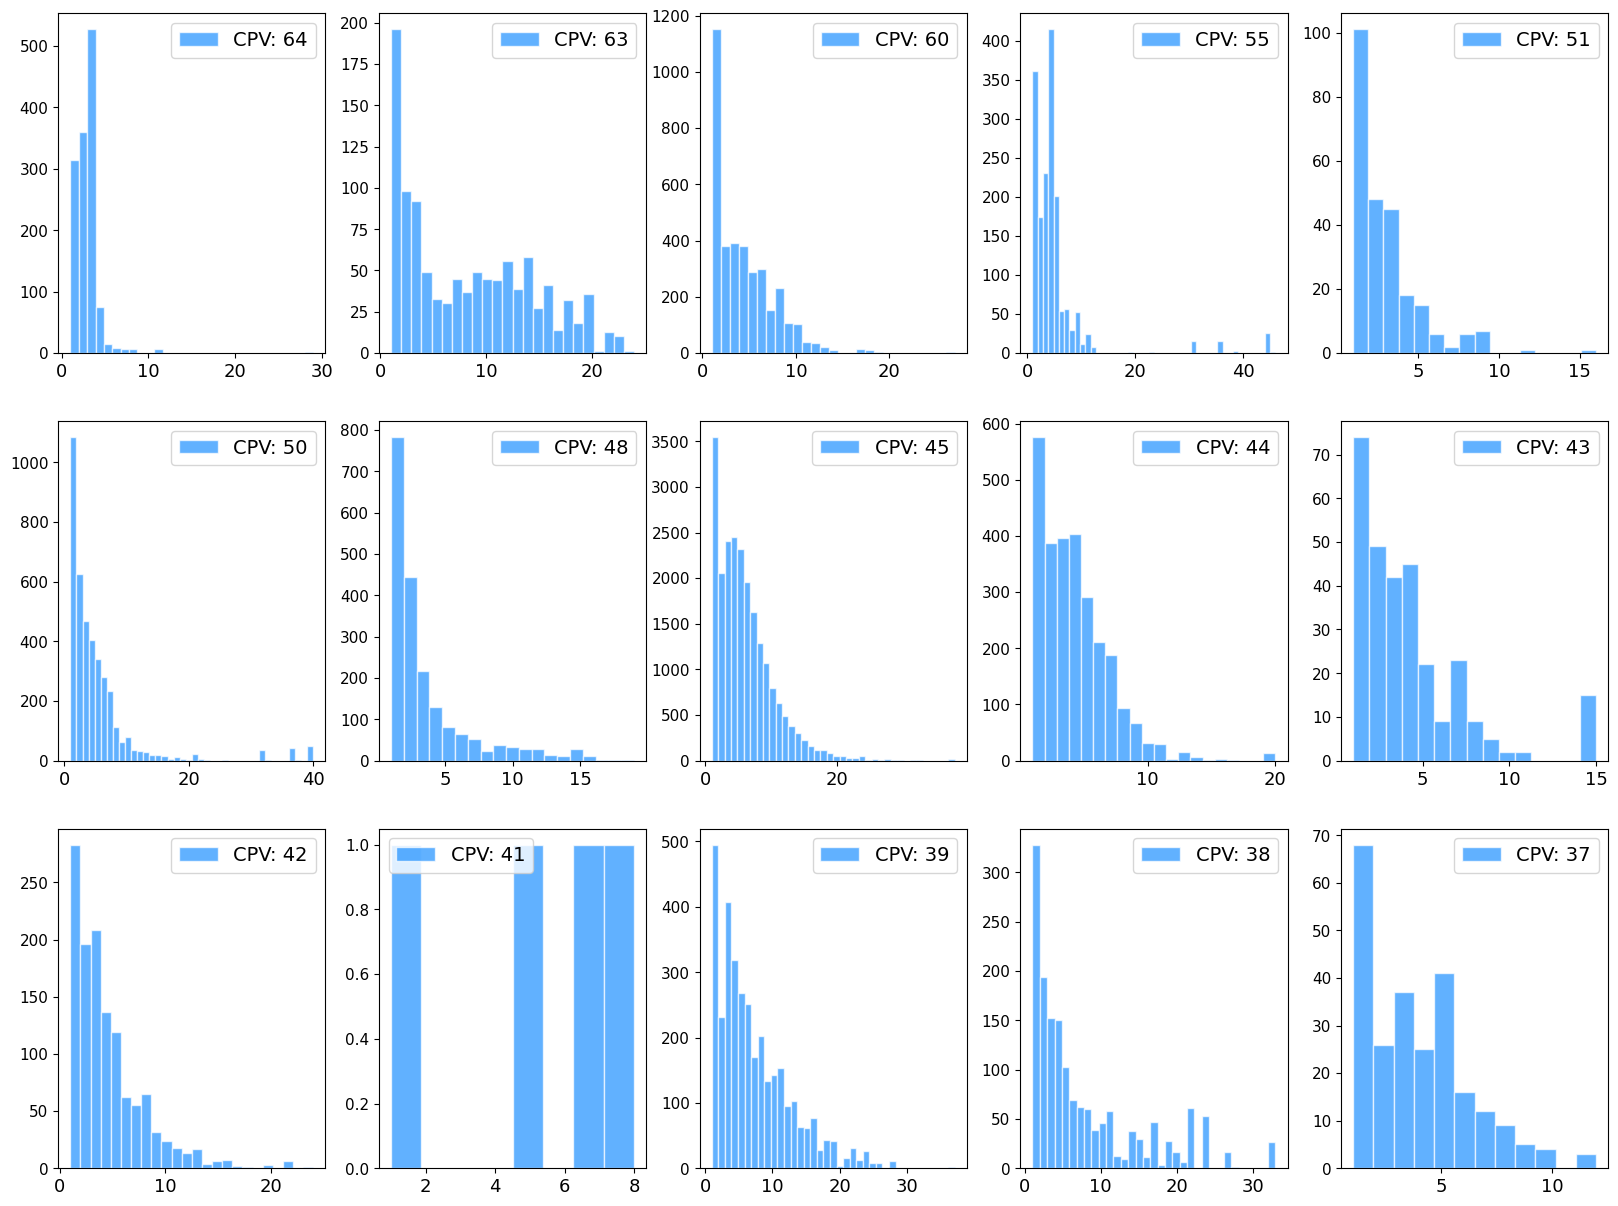

In [72]:
figure, axis = plt.subplots(3, 5, figsize=(20,15))

counter = 15

for i in range(3):
    for j in range(5):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]

        n_bins = np.max(np.unique(df))

        ax.hist(df, bins = n_bins, edgecolor='white', color='dodgerblue', alpha = .7, rwidth=1, label = 'CPV: ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best', fontsize = 14)
        ax.yaxis.set_tick_params(labelsize=11)
        ax.xaxis.set_tick_params(labelsize=13)
        
plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019_hist2.png',dpi = 500 ,bbox_inches='tight')
plt.show()

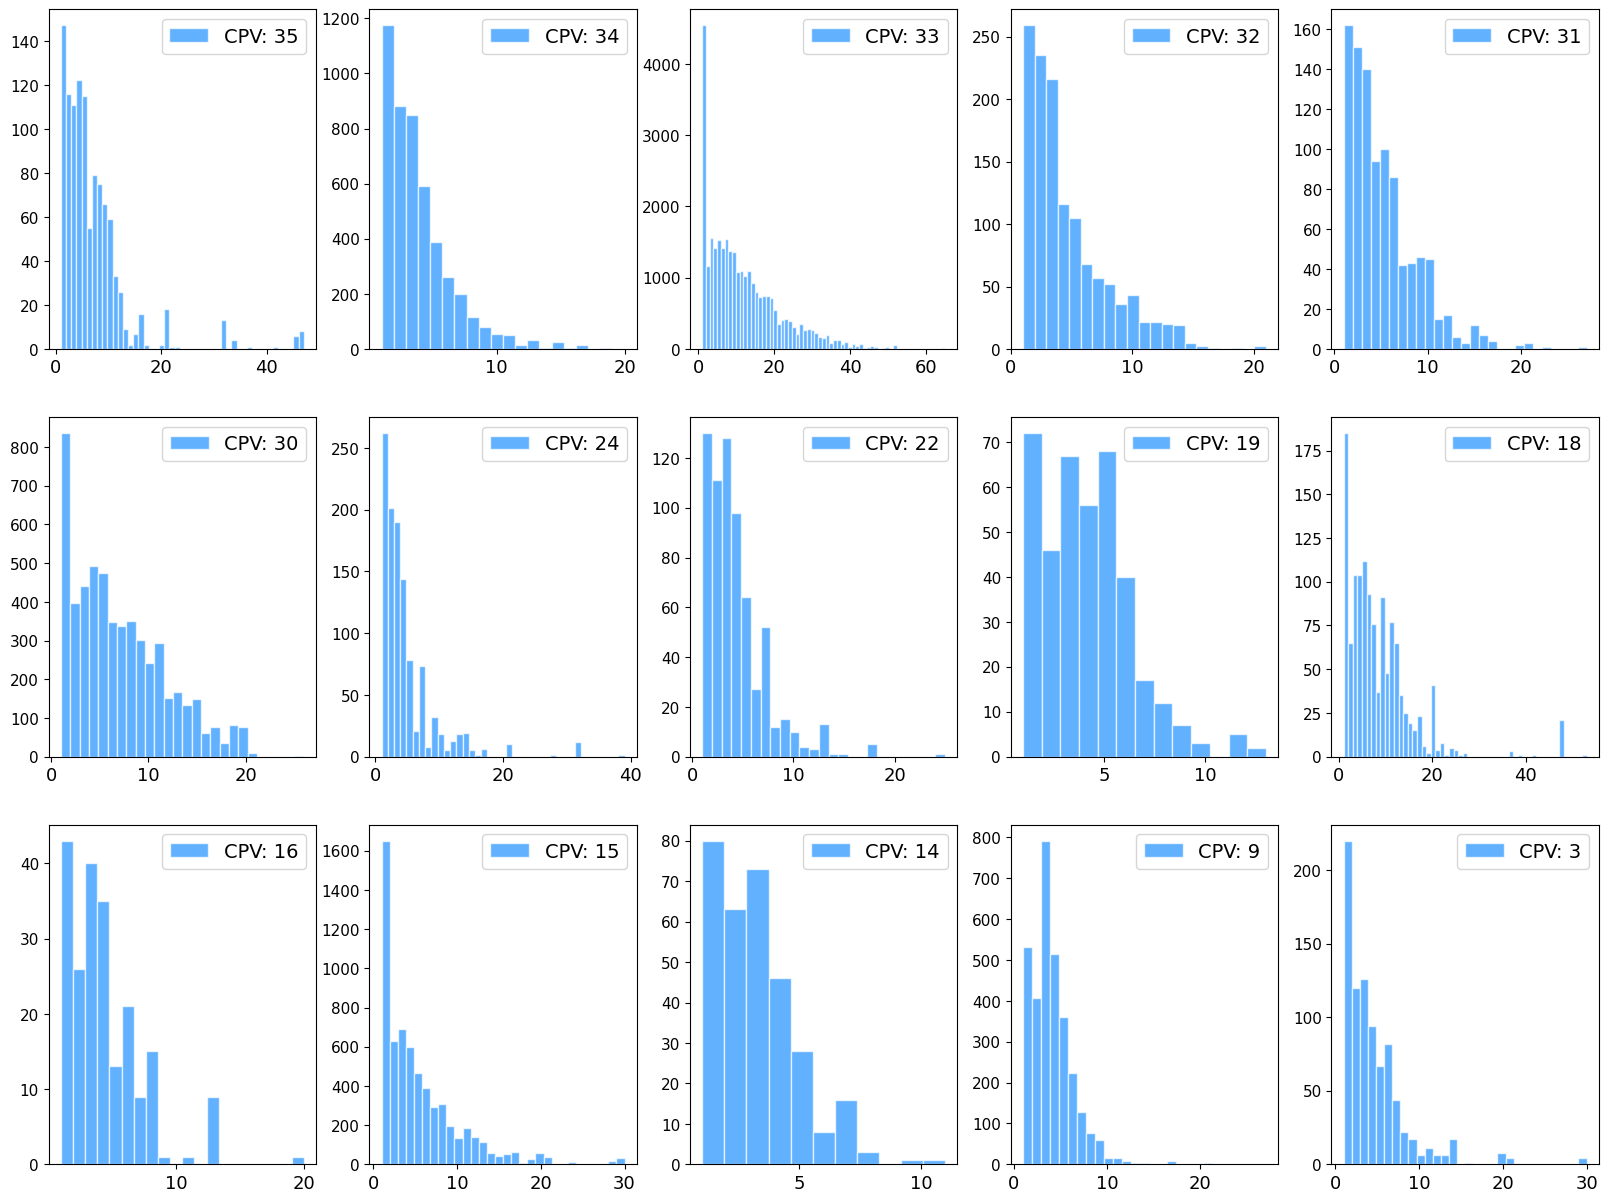

In [73]:
figure, axis = plt.subplots(3, 5, figsize=(20,15))

counter = 30

for i in range(3):
    for j in range(5):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]

        n_bins = np.max(np.unique(df))

        ax.hist(df, bins = n_bins, edgecolor='white', color='dodgerblue', alpha = .7, rwidth=1, label = 'CPV: ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best', fontsize = 14)
        ax.yaxis.set_tick_params(labelsize=11)
        ax.xaxis.set_tick_params(labelsize=13)
        
plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019_hist3.png',dpi = 500 ,bbox_inches='tight')
plt.show()

## Parte 1.2 : Cálculo Indicadores Estatísticos

**! SÓ VALE A PENA CORRER AS CÉLULAS DESTA SUBSECÇÃO UMA VEZ !**

In [212]:
m = np.zeros([len(CPV),10])

for i,j in enumerate(CPV):
    res = data.loc[data.iloc[:,0] == j ,data.columns[1]]
    m[i,1] = res.values.sum()
    m[i,2:] = list(res.describe())

m = pd.DataFrame(m)

In [213]:
m.iloc[:,0] = CPV

In [214]:
m = m.to_numpy()

In [215]:
table_name = 'cpv_stat'
column_names = ['cpv', 'nec_t', 'count', 'mean', 'std', 'min', 'q1', 'q2', 'q3', 'max']


# Correr apenas uma vez. Caso contrário, adiciona linhas com a mesma info

#for row in m:
#    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({});").format(
#        sql.Identifier(table_name),
#        sql.SQL(',').join(sql.Identifier(name) for name in column_names),
#        sql.SQL(',').join(sql.Literal(value) for value in row)
#    )
#    cur.execute(insert_query)

conn.commit()

## Parte 1.3: Plot dos boxplots do NEC para cada divisão

/tmp/ipykernel_67629/3904184396.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(res1, showfliers=False, labels=CPV[0:26])


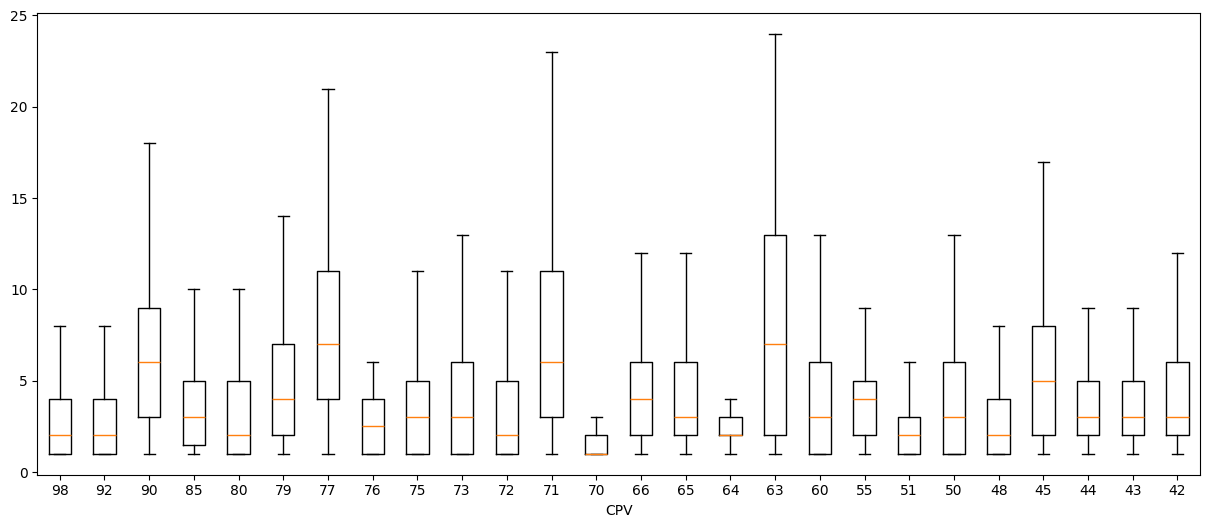

In [12]:
plt.figure(figsize=(15,6))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[1]].values for c in CPV[0:26]]
plt.boxplot(res1, showfliers=False, labels=CPV[0:26])

plt.xlabel('CPV')
#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv1.png', dpi = 400, bbox_inches='tight')
plt.show()

/tmp/ipykernel_67629/1072861204.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(res1, showfliers=False, labels=CPV[27:-1])


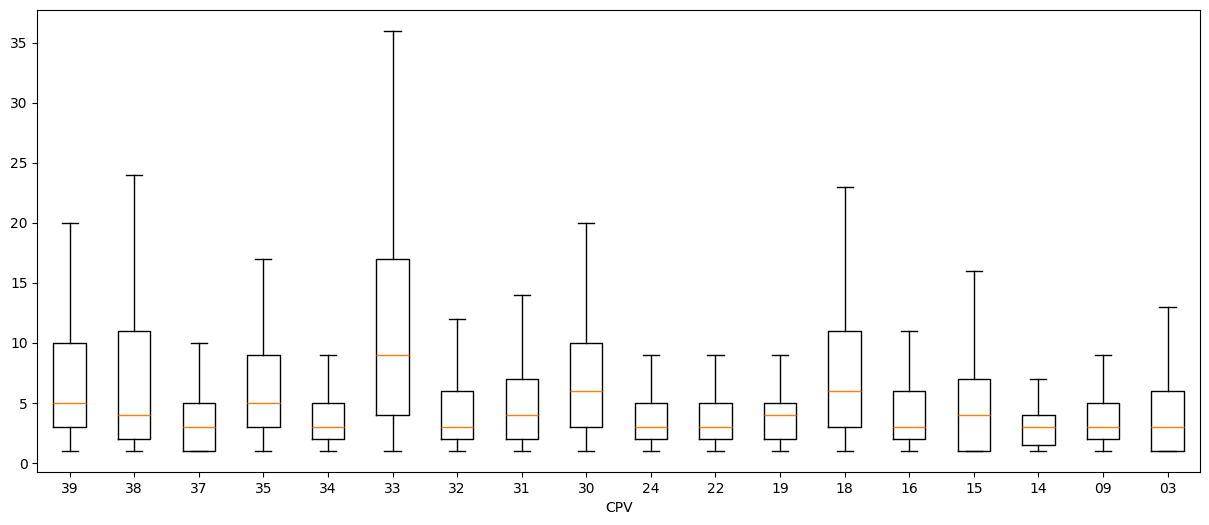

In [13]:
plt.figure(figsize=(15,6))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[1]].values for c in CPV[27:-1]]
plt.boxplot(res1, showfliers=False, labels=CPV[27:-1])

plt.xlabel('CPV')
#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv2.png', dpi = 400, bbox_inches='tight')
plt.show()

/tmp/ipykernel_67629/391110838.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(res1, showfliers=False, labels=CPV[0:-1].astype(int), vert=False)


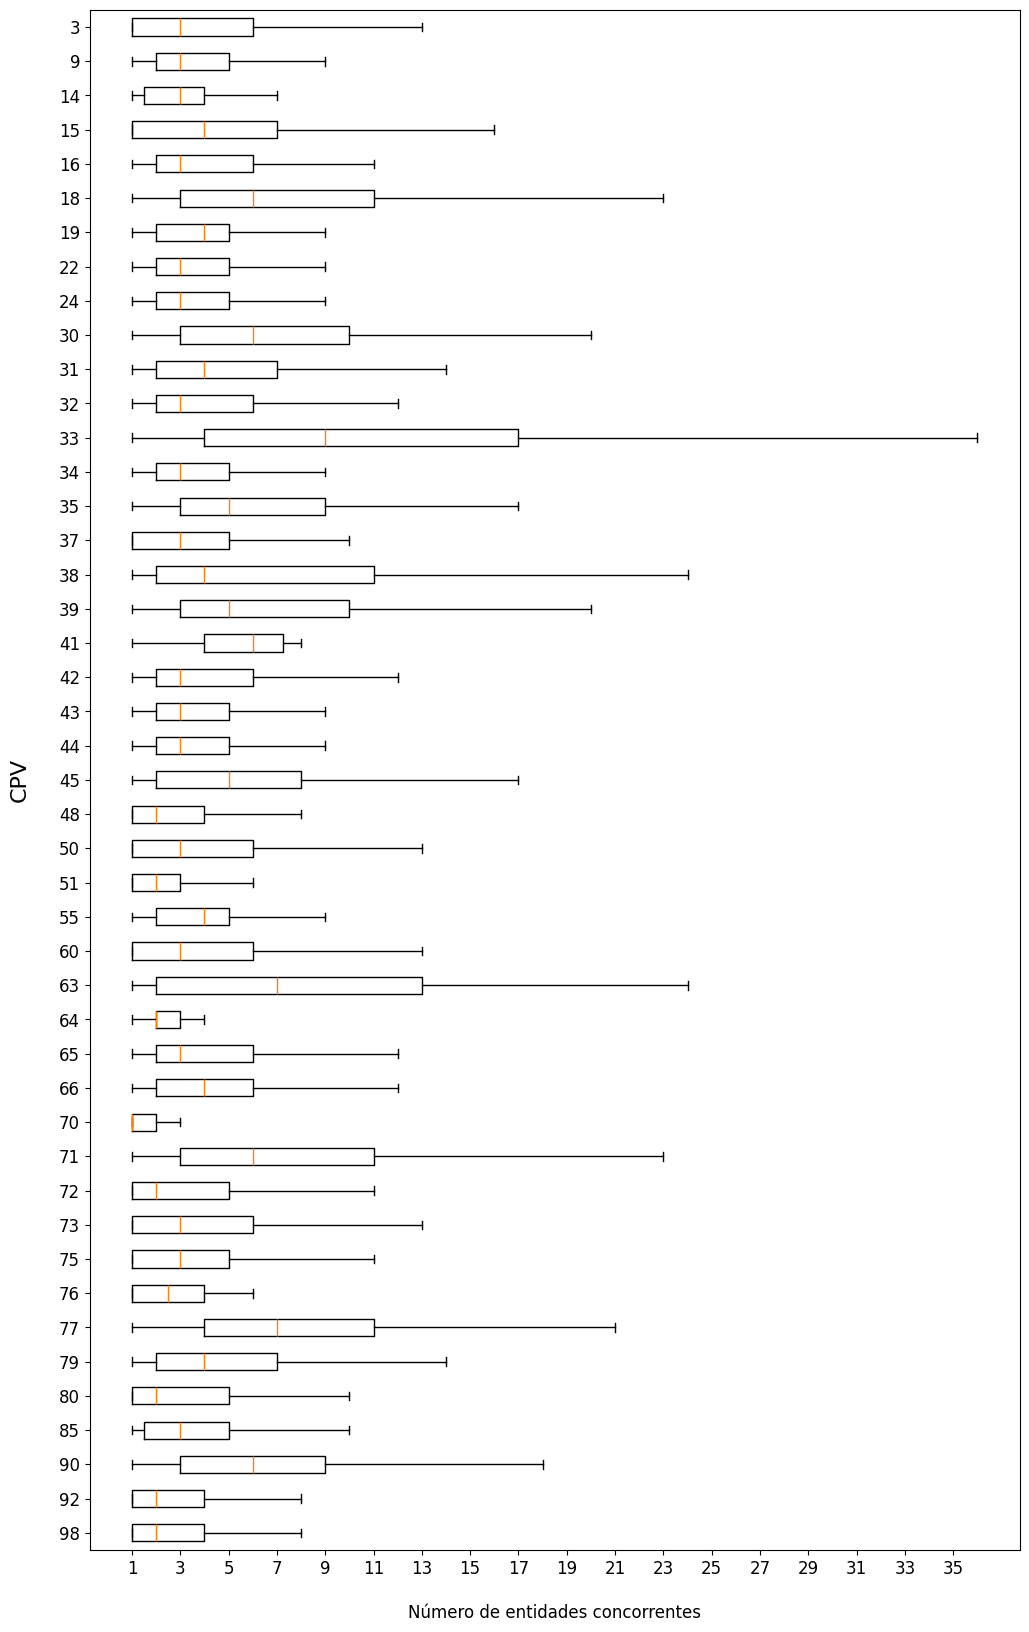

In [28]:
#meds = df2.median()
#meds.sort_values(ascending=False, inplace=True)
#df2 = df2[meds.index]
#df2.boxplot()


plt.figure(figsize=(12,20))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[1]].values for c in CPV[0:-1]]


plt.boxplot(res1, showfliers=False, labels=CPV[0:-1].astype(int), vert=False)

plt.xlabel('\nNúmero de entidades concorrentes', fontsize = 12)
plt.ylabel('CPV\n', fontsize = 16)
plt.xticks(np.arange(1,36,2), fontsize = 12)
plt.yticks(fontsize = 12)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv3.png', dpi = 700, bbox_inches='tight')

plt.show()

# PARTE 2 

Construir nova tabela com indicadores estatísticos para concursos públicos por CPV e por tipo de contrato

Tipo de contrato tem 3 categorias : 
- Bens e Serviços
- Empreitadas
- Outro

Formato tabela :

- CPV | TipoContrato | NEC Total | NºConcursos | Indicadores Estatísticos

In [194]:
cur = conn.cursor()
cur.execute('''
            SELECT cpv2, tipocontrato, nr_entidadesconcorrentes
            FROM concursospublicos
            ORDER BY cpv2 DESC;
            ''')

data1 = pd.DataFrame(cur.fetchall())

In [195]:
# CONJUNTO DE CPV's
cpv = (data1.iloc[:,0].unique())
cpv

array(['98', '92', '90', '85', '80', '79', '77', '76', '75', '73', '72',
       '71', '70', '66', '65', '64', '63', '60', '55', '51', '50', '48',
       '45', '44', '43', '42', '41', '39', '38', '37', '35', '34', '33',
       '32', '31', '30', '24', '22', '19', '18', '16', '15', '14', '09',
       '03', '00'], dtype=object)

In [208]:
#TIPOS DE CONTRATO
tc = data1.iloc[:,1].unique()
tc

array(['Bens e Serviços', 'Empreitadas', 'Outro'], dtype=object)

In [215]:
# data.loc[data.iloc[:,0] == j ,data.columns[2]]

#data1.loc[data1.iloc[:,0] == '98', data1.iloc[:,1] == 'Bens e Serviços', data.columns[2]]
data1.loc[(data1.iloc[:, 0] == '98') & (data1.iloc[:, 1] == 'Bens e Serviços'), data1.columns[2]].values.sum()


1723

In [249]:
Mm = np.zeros([len(cpv)*3,11], dtype=object)

cpv_rep = np.repeat(cpv,3)
Mm[:,0] = cpv_rep

for i in range(0,len(cpv_rep),3):
    for j in range(3):
        
        Mm[i+j,1] = tc[j]
        
        res = data1.loc[(data1.iloc[:, 0] == cpv_rep[i]) & (data1.iloc[:, 1] == tc[j]), data1.columns[2]]
        
        Mm[i+j,2] = res.values.sum()
        Mm[i+j,3:] = res.describe()


In [268]:
table_name = 'cpv_stat1'
column_names = ['cpv', 'tipocontrato', 'nec_t', 'count', 'mean', 'std', 'min', 'q1', 'q2', 'q3', 'max']


# Correr apenas uma vez. Caso contrário, adiciona linhas com a mesma info
for row in Mm:
    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({});").format(
        sql.Identifier(table_name),
        sql.SQL(',').join(sql.Identifier(name) for name in column_names),
        sql.SQL(',').join(sql.Literal(int(value)) if isinstance(value, np.int64) else sql.Literal(value) for value in row)
    )
    cur.execute(insert_query)

conn.commit()

In [275]:
data1.rename(columns={0:'CPV', 1:'Tipo de Contrato', 2:'Values'}, inplace=True)

In [276]:
data1

,CPV,Tipo de Contrato,Values
0,98,Bens e Serviços,1
1,98,Bens e Serviços,5
2,98,Bens e Serviços,1
3,98,Bens e Serviços,2
4,98,Bens e Serviços,4
...,...,...,...
103711,00,Outro,1
103712,00,Outro,1
103713,00,Outro,1
103714,00,Outro,1


In [287]:
res1 = [[data1.loc[(data1['CPV'] == c) & (data1['Tipo de Contrato'] == cc), 'Values'].values for cc in tc] for c in cpv_rep].size > 20
res1

AttributeError: 'list' object has no attribute 'size'

In [286]:
data1

,CPV,Tipo de Contrato,Values
0,98,Bens e Serviços,1
1,98,Bens e Serviços,5
2,98,Bens e Serviços,1
3,98,Bens e Serviços,2
4,98,Bens e Serviços,4
...,...,...,...
103711,00,Outro,1
103712,00,Outro,1
103713,00,Outro,1
103714,00,Outro,1


# PARTE 3

Plots para comparar média, std e mediana por CPV

In [66]:
cur = conn.cursor()
cur.execute('''
                SELECT *
                FROM cpv_stat;''')

tabela = pd.DataFrame(cur.fetchall())

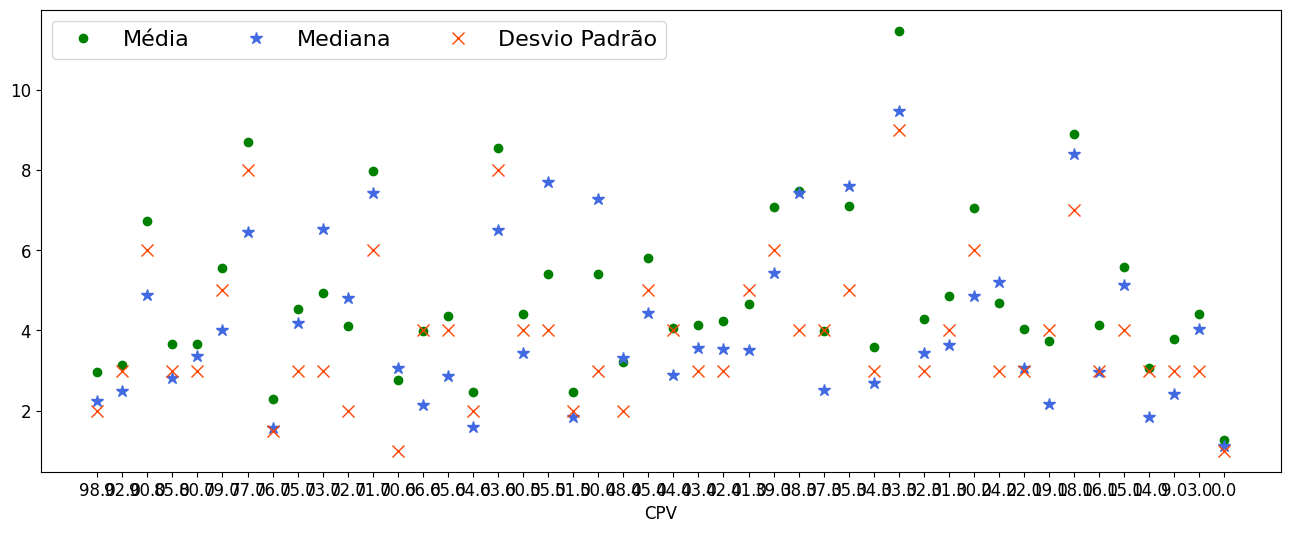

In [67]:
plt.figure(figsize=(16,6))


for i in range(len(tabela)):
    
    cpv = tabela.iloc[i, tabela.columns[0]]
    media = tabela.iloc[i, tabela.columns[3]]
    mediana = tabela.iloc[i, tabela.columns[4]]
    std = tabela.iloc[i, tabela.columns[7]]

    plt.plot(i, media, 'o', color='green', ms = 6, label=f'{cpv}')
    plt.plot(i, mediana, '*', color='royalblue', ms = 9)
    plt.plot(i, std, 'x', color='orangered', ms = 9)

plt.legend(loc='best', labels=['Média', 'Mediana', 'Desvio Padrão'], ncol = 3, fontsize = 16)
plt.xticks(np.arange(len(tabela)), CPV, rotation=0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('CPV', fontsize = 12)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/mmdp.png', dpi = 400, bbox_inches='tight')

plt.show()

# Parte 4 : Adaptação da fence

- Guardar num array as 46 categorias de 2 dígitos do CPV

In [216]:
cur = conn.cursor()

cur.execute('''
                SELECT SUBSTRING(cpv,1,2)
                FROM contratos_basegov
            ''')

cpv_xx = pd.DataFrame(item[0] for item in cur.fetchall())

In [217]:
cpvXX = cpv_xx.iloc[:,0].unique()

In [218]:
cpvXX

array(['79', '33', '60', '15', '18', '85', '90', '71', '66', '50', '64',
       '42', '65', '80', '44', '31', '45', '98', '32', '30', '09', '55',
       '35', '34', '72', '39', '73', '92', '63', '70', '22', '77', '38',
       '03', '41', '51', '24', '75', '48', '43', '14', '37', '16', '19',
       '76', ''], dtype=object)

In [227]:
#mc_values = list()
#
#cur = conn.cursor()
#for i in (cpvXX[::-1]):
#
#    df = data.loc[data["cpv"] == i, "nec"].values
#
#    if len(df) < 10000:
#    
#        const = float(medcouple(df))
#        mc_values.append([i, const])
#       
#        cur.execute('''
#                    UPDATE cpv_stat SET medcouple_constant = %s WHERE cpv_stat."cpv" = %s;
#                   ''', (const, str(i)))
#
#        
#conn.commit()

In [230]:
valores_add = list()

cur = conn.cursor()

for i in (cpvXX[::-1]):

    cur.execute('''
                SELECT q1, q2, q3, dq, mean, medcouple_constant
                FROM cpv_stat
                WHERE cpv_stat."cpv" = %s;
               ''', (str(i),))
    
    q1,q2,q3,iqr,mean,mc = (cur.fetchall()[0])
    
    if mc != None: 

        # A lower bound foi definida com o parâmero de 0.2 e a upper bound com o parâmetro 1
        # O 0.2 foi definido para que todos os lower bounds sejam positivos
        # O upper bound foi definido para apanhar algunda 'outliers' / observações de alguns histogramas que aparentemente
        # são suspeitas
        #print(i,':', round(mean,1), q2,q1,q3,round(lf,2), round(uf,2))
        
        lf = q1 - .2*np.exp(-4*mc)*iqr
        uf = q3 + 1*np.exp(3*mc)*iqr

        valores_add.append([i,lf,uf])

    else :
        # Defini lower bound como q1 porque estes dois casos correspondem aos CPVs cuja constante de Medcouple demora muito a calcular e bloqueia o pc
        # Um deles é cpv 45 e, como diz respeito a construção civil, é normal candidatarem-se muitas empresas ( média 11.48 | mediana 9
        # Outro é cpv 33, que diz respeito à área da saúde, e em média candidatam-se 5.8 empresas e a mediana é 5 também
        # Como pelos histogramas existem muitos contratos com apenas uma NEC, vai ser considerado o lower bound como o primeiro quartil que, em 
        # ambos os CPVs, é superior a 1
        lf = q1
        uf = q3 + 1.5*iqr
        
        valores_add.append([i,lf,uf])

conn.commit()

In [231]:
cur = conn.cursor()

for i in valores_add:
    cpv, lf, uf = i

    cur.execute('''
                UPDATE cpv_stat
                SET lower_fence = %s, upper_fence = %s
                WHERE cpv_stat."cpv" = %s;
                ''', (lf, uf, str(cpv)))

conn.commit()

**Número de concursos públicos por CPV**

In [68]:
cur = conn.cursor()
cur.execute('''
            select SUBSTRING(contratos_basegov."cpv", 1, 2), count(*)
            from contratos_basegov
            where tipo_procedimento = 'Concurso público'
            group by SUBSTRING(contratos_basegov."cpv", 1, 2)
            order by count(*) desc;
            ''')

cur.fetchall()

[('33', 27198),
 ('45', 21299),
 ('15', 5849),
 ('30', 5178),
 ('90', 4799),
 ('34', 4458),
 ('79', 4331),
 ('71', 4101),
 ('50', 3786),
 ('72', 3660),
 ('60', 3495),
 ('66', 3230),
 ('39', 3148),
 ('09', 2970),
 ('44', 2541),
 ('48', 1928),
 ('77', 1823),
 ('55', 1634),
 ('38', 1547),
 ('85', 1520),
 ('64', 1249),
 ('18', 1215),
 ('32', 1210),
 ('42', 1187),
 ('24', 1049),
 ('35', 1036),
 ('63', 992),
 ('31', 927),
 ('03', 817),
 ('92', 807),
 ('98', 695),
 ('22', 645),
 ('80', 621),
 ('65', 421),
 ('19', 373),
 ('14', 299),
 ('43', 287),
 ('51', 239),
 ('37', 232),
 ('16', 211),
 ('75', 169),
 ('73', 143),
 ('70', 48),
 ('76', 40),
 ('', 7),
 ('41', 4)]

**Calcular o histograma apenas para as entidades concorrentes para CPV 45**

In [91]:
cur = conn.cursor()
cur.execute('''
            SELECT nr_entidadesconcorrentes
            FROM concursos_publicos
            JOIN contratos_basegov ON contratos_basegov."id" = concursos_publicos."id"
            WHERE SUBSTRING(contratos_basegov."cpv", 1, 2) = %s;
            ''', ('45',))

ccivil = list(i[0] for i in cur.fetchall())

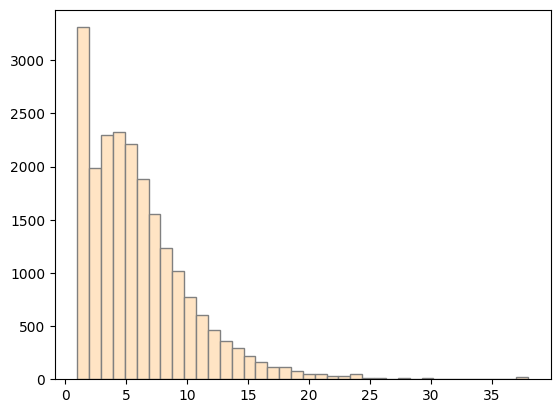

In [92]:
n_bins = np.max(np.unique(ccivil))

plt.hist(ccivil, bins = n_bins, edgecolor='gray', color = 'bisque')
plt.show()

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


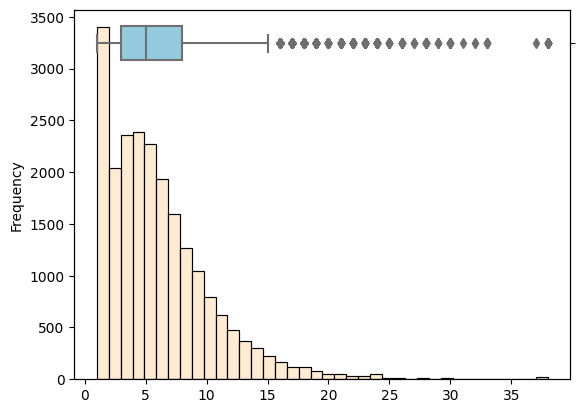

In [93]:
ax = sns.histplot(ccivil, kde=False, stat='frequency', bins=n_bins, color='bisque', edgecolor='black')
ax2 = ax.twinx()
sns.boxplot(x=ccivil, ax=ax2, width=0.5, color='skyblue')
ax2.set(ylim=(-5, .5))
plt.show()

**Calcular o histograma apenas para as entidades concorrentes para CPV 33**

In [43]:
cur = conn.cursor()
cur.execute('''
            SELECT nr_entidadesconcorrentes
            FROM concursos_publicos
            JOIN contratos_basegov ON contratos_basegov."id" = concursos_publicos."id"
            WHERE SUBSTRING(contratos_basegov."cpv", 1, 2) = %s;
            ''', ('33',))

saude = list(i[0] for i in cur.fetchall())

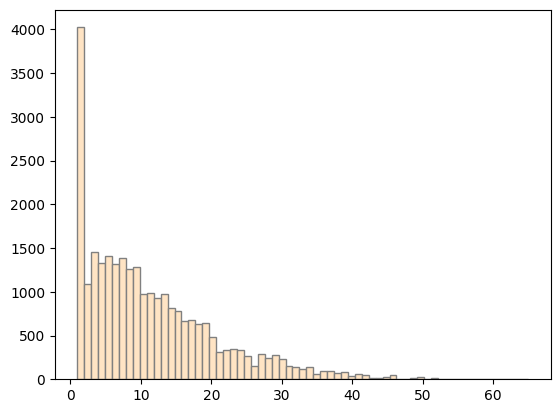

In [44]:
n_bins = np.max(np.unique(saude))

plt.hist(saude, bins = n_bins, edgecolor='gray', color = 'bisque')
plt.show()

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


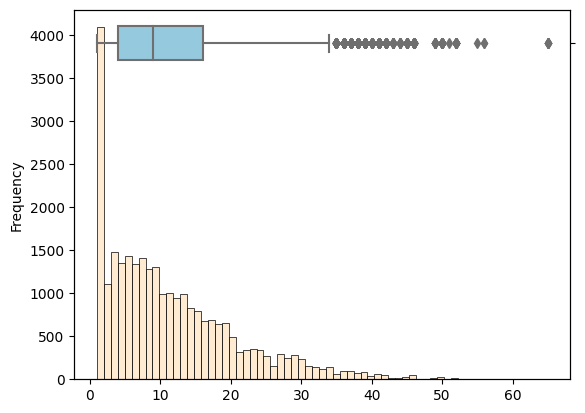

In [90]:
ax = sns.histplot(saude, kde=False, stat='frequency', bins=n_bins, color='bisque', edgecolor='black')
ax2 = ax.twinx()
sns.boxplot(x=saude, ax=ax2, width=0.5, color='skyblue')
ax2.set(ylim=(-5, .5))
plt.show()